In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler

In [2]:
df_envi_inter = pd.read_csv("../../../DataSet/Envi/envi_inter.csv")

df_envi_inter

,Date,Envi
0,04/01/2015,44562
1,11/01/2015,38112
2,18/01/2015,50355
3,25/01/2015,51922
4,01/02/2015,67496
...,...,...
164,25/02/2018,42116
165,04/03/2018,44454
166,11/03/2018,28399
167,18/03/2018,49145


In [3]:
df_envi_inter["Date"] = pd.to_datetime(df_envi_inter["Date"], unit="ns")

In [4]:
df_envi_inter["y"] = df_envi_inter["Envi"].shift(-1)
df_envi_inter.dropna(inplace=True)
df_envi_inter

,Date,Envi,y
0,2015-04-01,44562,38112.0
1,2015-11-01,38112,50355.0
2,2015-01-18,50355,51922.0
3,2015-01-25,51922,67496.0
4,2015-01-02,67496,54229.0
...,...,...,...
163,2018-02-18,39773,42116.0
164,2018-02-25,42116,44454.0
165,2018-04-03,44454,28399.0
166,2018-11-03,28399,49145.0


In [5]:
def findBestRandomState(r,t, x, y):
    random = 0
    a = 100

    model = RegressorChain(GradientBoostingRegressor())
    for _ in range(r,t):
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=_)
        model.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))

        y_predict = model.predict(x_test.reshape(-1, 1))
        if (buff := mean_absolute_error(y_test, y_predict)) < a:
            a = buff
            random = _
        # print(f"The Mean Square Error: {mean_squared_error(y_test, y_predict)}")
        # print(f"The R2 score: {r2_score(y_test, y_predict)}")
    print(a, random)

x = np.array(df_envi_inter["Envi"]).reshape(-1, 1)
y = np.array(df_envi_inter["y"]).reshape(-1, 1)

# scaler = StandardScaler()
# scaler.fit(x)
# x = scaler.transform(x.reshape(-1, 1))

# scaler.fit(y)
# y = scaler.transform(y.reshape(-1, 1))



# findBestRandomState(200000,300000,x,y)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=157086)

# seed 2110 MAE: 0.38
# seed 2110 learningRate 0.075, loss huber: MAE: 0.365

# seed 157086 MAE: 0.3345
# seed 157086 learningRate 0.049 MAE: 0.31832

Mean Absolute Error: 3108.154219341137
Mean Square Error: 17697432.443556175
R2 score: 0.7616186953690786


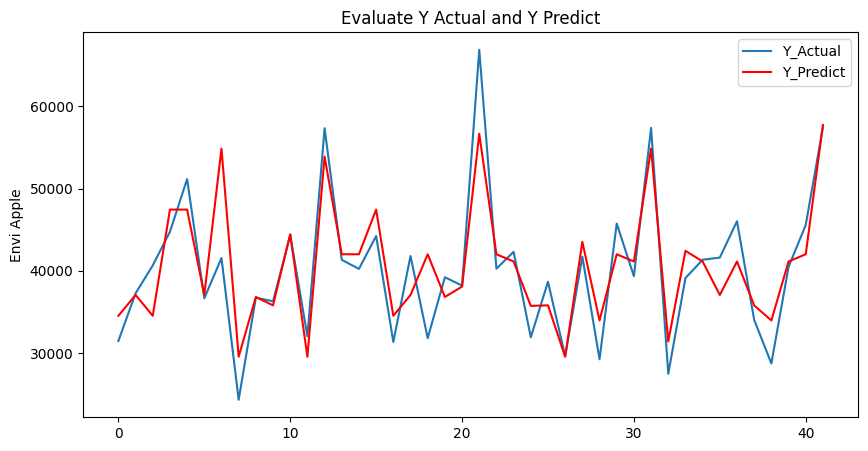

In [6]:
# ml = RegressorChain(GradientBoostingRegressor(learning_rate=0.075, loss='huber',alpha=0.96))
ml = RegressorChain(GradientBoostingRegressor(learning_rate=0.049, max_depth=3, max_leaf_nodes=4))
ml.fit(x_train, y_train)

y_pred = ml.predict(x_test)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Square Error: {mean_squared_error(y_test, y_pred)}")
print(f"R2 score: {r2_score(y_test, y_pred)}")

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Y_Actual')
plt.plot(y_pred, color='red', label='Y_Predict')
plt.ylabel("Envi Apple")
plt.legend()
plt.title("Evaluate Y Actual and Y Predict")
plt.show()